In [ ]:
import torch
import torchvision

In [ ]:
%%capture
!pip install neptune-client

In [ ]:
%%capture
!pip install transformers

In [ ]:
%%capture
!pip install pytorch-lightning

In [ ]:
%%capture
!pip install torchmetrics

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import transformers
import pytorch_lightning as pl
import torchmetrics

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 42

sns.set(style = "whitegrid", palette= "muted", font_scale= 1.2)
rcParams["figure.figsize"] = 12, 8

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_json("./en-train.json", lines= True)
df.head()

,id,text,label
0,100000,Schools 'need to adopt green approach'\nPUBLIS...,0
1,100001,"IN SCHOOL\nKerber, defending Graf’s record, ge...",0
2,100002,Microsoft launches Xbox Music on Web for free\...,0
3,100003,"PUBLISHED : Sunday, 20 February, 2000, 12:00am...",0
4,100004,Stocks to bounce back: fund managers\nTNN | Se...,0


In [ ]:
test_df = pd.read_json("./test.json", lines = True)

In [ ]:
df.drop_duplicates(subset= "text",inplace= True)

####

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
# train_df = df

In [ ]:
LABEL_COLUMNS = ["label"]

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels)

SIT fails to serve notice on Mani 14th November 2012 10:43 AM The Special Investigation Team (SIT), probing the murder of Youth Congress leader Anchery Baby, failed to serve notice for polygraph test on former CPM Idukki secretary M M Mani and another accused Kynakari Kuttan on Tuesday. However, th

label    1
Name: 16, dtype: object


change model name for different bert models

In [ ]:
BERT_MODEL_NAME = "albert-base-v2"  # roberta-base  bert-base-uncased bert-base-cased ablert-base-v2
tokenizer = transformers.AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
encoding = tokenizer.encode_plus(
    sample_comment,
    add_special_tokens = True,
    max_length = 512,
    return_token_type_ids = False,
    padding = "max_length",
    return_attention_mask = True,
    return_tensors = "pt",
)

In [ ]:
tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20]

['[CLS]',
 '▁sit',
 '▁fails',
 '▁to',
 '▁serve',
 '▁notice',
 '▁on',
 '▁',
 'mani',
 '▁14',
 'th',
 '▁november',
 '▁2012',
 '▁10',
 ':43',
 '▁am',
 '▁the',
 '▁special',
 '▁investigation',
 '▁team']

In [ ]:
class ToxicCommentsDataset(torch.utils.data.Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: transformers.BertTokenizer, max_token_len: int = 128, testData = False):
    
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
    self.test_data = testData

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.text
    labels = []

    if not self.test_data:
      labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
        comment_text,
        add_special_tokens = True,
        max_length = self.max_token_len,
        return_token_type_ids = False,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        return_tensors = "pt",
    )

    if not self.test_data:
      return dict(
          comment_text = comment_text,
          input_ids = encoding["input_ids"].flatten(),
          attention_mask = encoding["attention_mask"].flatten(),
          labels = torch.FloatTensor(labels)
      )
    else:
      return dict(
          comment_text = comment_text,
          input_ids = encoding["input_ids"].flatten(),
          attention_mask = encoding["attention_mask"].flatten()
      )

In [ ]:
train_dataset = ToxicCommentsDataset(train_df, tokenizer)

In [ ]:
sample_item = train_dataset[0]

In [ ]:
bert_model = transformers.AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict = True)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
prediction = bert_model(sample_item["input_ids"].unsqueeze(dim = 0), sample_item["attention_mask"].unsqueeze(dim = 0))
prediction.last_hidden_state

tensor([[[ 0.3095, -0.1611,  1.9313,  ..., -2.5406,  0.3842,  0.5426],
         [ 0.1625, -0.9160,  1.6532,  ..., -0.3501,  0.3582, -0.8521],
         [ 0.0751, -1.8302,  2.0017,  ..., -0.5146,  1.4128, -1.7094],
         ...,
         [-1.1504,  0.5194,  1.8193,  ...,  0.5905,  1.0625, -0.9089],
         [-1.0539, -0.4123,  1.4703,  ...,  0.2754,  1.4245, -1.1051],
         [ 0.0448,  0.0788, -0.0754,  ..., -0.0714,  0.1322,  0.1727]]],
       grad_fn=<NativeLayerNormBackward>)

In [ ]:
class ToxicCommentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size = 8, max_token_len = 128):
    super().__init__()

    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self):
    self.train_dataset = ToxicCommentsDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.val_dataset = ToxicCommentsDataset(
        self.val_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len,
        testData = True
    )

  def train_dataloader(self):
    return torch.utils.data.DataLoader(
        self.train_dataset,
        self.batch_size,
        shuffle = True,
        num_workers = 2
    )

  def val_dataloader(self):
    return torch.utils.data.DataLoader(
        self.val_dataset,
        batch_size = 1,
        shuffle = False,
        num_workers = 2
    )

  def test_dataloader(self):
    return torch.utils.data.DataLoader(
        self.test_dataset,
        batch_size = 1,
        shuffle = False,
        num_workers = 2
    )

In [ ]:
N_EPOCHS = 30
BATCH_SIZE = 32

data_module = ToxicCommentDataModule(train_df, val_df, test_df, tokenizer, BATCH_SIZE)
data_module.setup()

In [ ]:
criterion = torch.nn.BCELoss()

In [ ]:
class ToxicCommentTagger(pl.LightningModule):
  def __init__(self, n_classes: int, steps_per_epoch = None, n_epochs = None, learning_rate = 5e-5):
    super().__init__()

    self.bert = transformers.AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict = True)
    self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
    self.steps_per_epoch = steps_per_epoch
    self.learning_rate = learning_rate
    self.n_epochs = n_epochs
    self.criterion = torch.nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels = None):
    output = self.bert(input_ids, attention_mask = attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)

    loss = 0
    if labels != None:
      loss = self.criterion(output, labels)

    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    
    loss, output = self(input_ids, attention_mask, labels)

    self.log("train_loss", loss, prog_bar = True, logger = True)

    return {"loss": loss, "predictions": output, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    
    loss, output = self(input_ids, attention_mask, labels)

    self.log("val_loss", loss, prog_bar = True, logger = True)

    return {"loss": loss, "predictions": output, "labels": labels}

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    
    loss, output = self(input_ids, attention_mask)

    # self.log("test_loss", loss, prog_bar = True, logger = True)

    return loss

  def training_epoch_end(self, outputs):
    labels = []
    predictions = []

    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels.int())

      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels)
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      #roc_score = torchmetrics.functional.auroc(predictions[:, i], labels[:, i])
      f1_macro = torchmetrics.functional.f1(predictions[:, i], labels[:, i], average= "macro", num_classes= 1)

      #self.logger.experiment.log_metric(f"{name}_roc_auc/Train", roc_score, self.current_epoch)
      self.logger.experiment.log_metric(f"{name}_f1macro/Train", f1_macro, self.current_epoch)

  def validation_epoch_end(self, outputs):
    labels = []
    predictions = []

    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels.int())

      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels)
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      #roc_score = torchmetrics.functional.auroc(predictions[:, i], labels[:, i])
      f1_macro = torchmetrics.functional.f1(predictions[:, i], labels[:, i], average= "macro", num_classes= 1)

      #self.logger.experiment.log_metric(f"{name}_roc_auc/Test", roc_score, self.current_epoch)
      self.logger.experiment.log_metric(f"{name}_f1macro/Test", f1_macro, self.current_epoch)

  def configure_optimizers(self):
    optimizer = transformers.AdamW(self.parameters(), lr= self.learning_rate)

    warmup_steps = self.steps_per_epoch // 3
    total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

    scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer,
        warmup_steps,
        total_steps
    )

    return [optimizer], [scheduler]

In [ ]:
model = ToxicCommentTagger(n_classes= 1, steps_per_epoch= len(train_df) // BATCH_SIZE, n_epochs= N_EPOCHS)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
_, prediction = model(sample_item["input_ids"].unsqueeze(dim = 0), sample_item["attention_mask"].unsqueeze(dim = 0))

In [ ]:

from pytorch_lightning.loggers import NeptuneLogger

neptune_logger = NeptuneLogger(
    api_key='',
    project_name='',
    experiment_name=BERT_MODEL_NAME,  # Optional,
    params={'max_epochs': 10},  # Optional,
    tags=['pytorch-lightning', 'mlp']  # Optional,
)

NeptuneLogger will work in online mode


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import  ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor='val_loss')

trainer = pl.Trainer(max_epochs= N_EPOCHS, gpus = 1, progress_bar_refresh_rate= 30, logger=neptune_logger,
                     callbacks=[
                                EarlyStopping(monitor='val_loss', patience=2), 
                                checkpoint_callback,
                                ]
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params
-------------------------------------------
0 | bert       | AlbertModel | 11.7 M
1 | classifier | Linear      | 769   
2 | criterion  | BCELoss     | 0     
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.737    Total estimated model params size (MB)


LR finder stopped early after 96 steps due to diverging loss.
Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


Learning rate set:  2.7542287033381663e-05


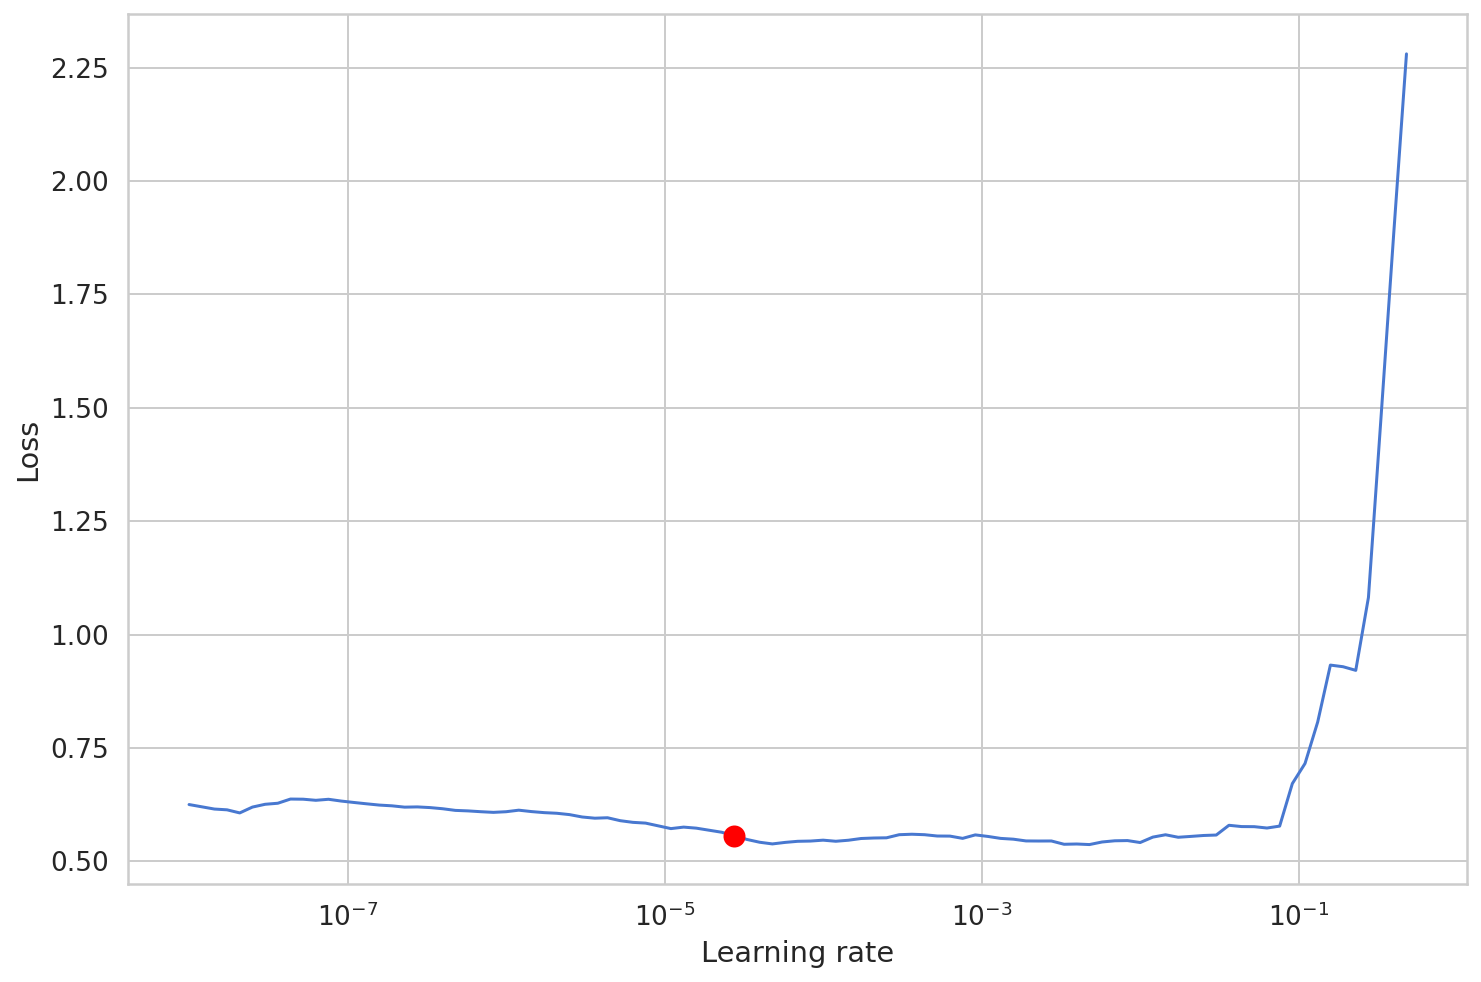

In [ ]:
lr_finder = trainer.tuner.lr_find(model, data_module.train_dataloader(), data_module.val_dataloader())

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

print("Learning rate set: ", new_lr)

model.learning_rate = new_lr

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import  ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor='val_loss')

trainer = pl.Trainer(max_epochs= N_EPOCHS, gpus = 1, progress_bar_refresh_rate= 30, logger=neptune_logger,
                     callbacks=[
                                EarlyStopping(monitor='val_loss', patience=2), 
                                checkpoint_callback,
                                ]
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


https://app.neptune.ai/despdair/Subtask-1/e/SUB-62



  | Name       | Type        | Params
-------------------------------------------
0 | bert       | AlbertModel | 11.7 M
1 | classifier | Linear      | 769   
2 | criterion  | BCELoss     | 0     
-------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.737    Total estimated model params size (MB)


Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/channels/channels_values_sender.py", line 157, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/experiments.py", line 1032, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 376, in send_channels_values
    self._execute_operations(experiment, send_operations)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hoste

Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/channels/channels_values_sender.py", line 157, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/experiments.py", line 1032, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 376, in send_channels_values
    self._execute_operations(experiment, send_operations)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hoste

Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/channels/channels_values_sender.py", line 157, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/experiments.py", line 1032, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 376, in send_channels_values
    self._execute_operations(experiment, send_operations)
  File "/usr/local/lib/python3.7/dist-packages/neptune/utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/neptune/internal/api_clients/hosted_api_clients/hoste

In [ ]:
# model.load_from_checkpoint(checkpoint_path= checkpoint_callback.best_model_path, n_classes = 1)

In [ ]:
model.freeze()

In [ ]:
device = torch.device("cuda:0")


In [ ]:
predictions = []
targets = []
for testObj in data_module.val_dataloader():
  _, test_pred = model(testObj["input_ids"], testObj["attention_mask"])
  targets.append(testObj["labels"])
  predictions.append(test_pred)

In [ ]:
prediction_np = []
for pred in predictions:
  prediction_np.append(pred.cpu().flatten().numpy()[0])

In [ ]:
targets_np = []
for t in targets:
  targets_np.append(int(t.flatten().numpy()[0]))

In [ ]:
import sklearn

maxScore = float("-inf")
maxScoreThreshold = 0
for t in range(1, 99, 1):
  score = sklearn.metrics.f1_score(np.array(targets_np), np.array(prediction_np) > (t / 100), average= "macro")

  if score > maxScore:
    maxScore = score
    maxScoreThreshold = t

print(f"For the threshold {maxScoreThreshold}, the system achievend highest F1-Macro score of {maxScore}")

For the threshold 38, the system achievend highest F1-Macro score of 0.843358451536643


In [ ]:
predictions = []
for testObj in data_module.test_dataloader():
  _, test_pred = model(testObj["input_ids"], testObj["attention_mask"])
  predictions.append(test_pred)

prediction_np = []
for pred in predictions:
  prediction_np.append(pred.cpu().flatten().numpy()[0])

In [ ]:
import pickle

with open("/content/drive/MyDrive/Case_2021_Related/Subtask_1/Final Predictions/" + BERT_MODEL_NAME + "_optim.pkl", "wb") as fout:
  pickle.dump(prediction_np, fout)